# My year of plastic in 10 charts

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
import numpy as np
from scipy import stats #for streamgraph
import seaborn as sns
import matplotlib.patches as patches
import pickle
from matplotlib import font_manager
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

from datetime import date, datetime

%matplotlib inline

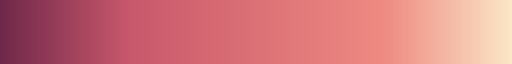

In [389]:
from palettable.cartocolors.sequential import Magenta_7, PurpOr_7, BluYl_7, DarkMint_7, BurgYl_5_r, BurgYl_7, BurgYl_7_r, Burg_7, BrwnYl_7
from palettable.colorbrewer.sequential import YlGnBu_9, Blues_9

col_red = "#d26e7b"

#set color palette
colpalette = BurgYl_7
colpalette_r = BurgYl_5_r
colpalette_r.mpl_colormap

In [4]:
# set root folder
root = os.path.abspath(os.path.join(os.getcwd(), ".."))

#get data - open pickled file
file = open(os.path.join(root, "data\\lisa_plastic_records_history_clean"),'rb')
df = pickle.load(file)
file.close()

#font_manager.findSystemFonts(fontpaths=None, fontext="ttf")
#set fonts for plots
font_r = font_manager.FontProperties(fname='C:\\Windows\\Fonts\\MYRIADPRO-REGULAR.OTF')
font_m = font_manager.FontProperties(fname='C:\\WINDOWS\\Fonts\\MYRIADPRO-SEMIBOLD.OTF')
font_b = font_manager.FontProperties(fname='C:\\WINDOWS\\Fonts\\MYRIADPRO-BOLD.OTF')

# Preparation

## aggregated data per day

In [5]:
#aggregate data by day + category
data_daily = df.groupby(["date", "category_name", "sub_category_name"]).agg({"plastic_weight":"sum",
                                                                            "score":"sum", 
                                                                            "quantity": "sum",
                                                                            "DV_plastic_weight":"sum"})
data_daily = data_daily.reset_index()

#get all days for 2021 and join with data
all_days = pd.DataFrame(pd.date_range('1/1/2021', periods=365, freq='D')).rename(columns={0:"date"})
df_daily = pd.merge(all_days, data_daily, left_on="date", right_on = "date", how='outer')

In [6]:
#get calendarweeks and month

df["ISOyear"] = df["date"].dt.isocalendar()["year"]
df["ISOweek"] = df["date"].dt.isocalendar()["week"]

#get weeks commencing
weeks = df[["ISOyear", "ISOweek"]].drop_duplicates().reset_index(drop=True)

week_commencing = []

for i in range(len(weeks)):
    x = pd.to_datetime(date.fromisocalendar(weeks["ISOyear"][i],weeks["ISOweek"][i],1))
    week_commencing.append(x)
    
weeks["week_commencing"] = week_commencing

#merge back to dataframe
df = pd.merge(df, weeks, left_on=["ISOyear", "ISOweek"], right_on=["ISOyear", "ISOweek"], how='left')

#get month based on weeks commencing
df["month"] = df["week_commencing"].dt.month
df.loc[df["week_commencing"] =="2020-12-28", "month"] = 1

# 0. Overview poster

## Total weight

In [7]:
df["DV_plastic_weight"].sum()/2

15967.0

## Total weight per category

In [8]:
pivot = df.groupby("category_name")["DV_plastic_weight"].sum().to_frame()
pivot = pivot.sort_values(by="DV_plastic_weight", ascending=False)
pivot["Percent"] = pivot["DV_plastic_weight"]/ (pivot["DV_plastic_weight"].sum()) *100
pivot

,DV_plastic_weight,Percent
category_name,,
"Pots, tubs, trays",10821,33.885514
Bottles,10707,33.528528
Bags and film,6096,19.089372
Cupboard and Hygiene,3280,10.271184
Other,968,3.031252
Drinks,62,0.19415


In [ ]:
['Pots, tubs, trays', 'Bottles', 'Bags and film', 'Cupboard and Hygiene', 'Other', 'Drinks']

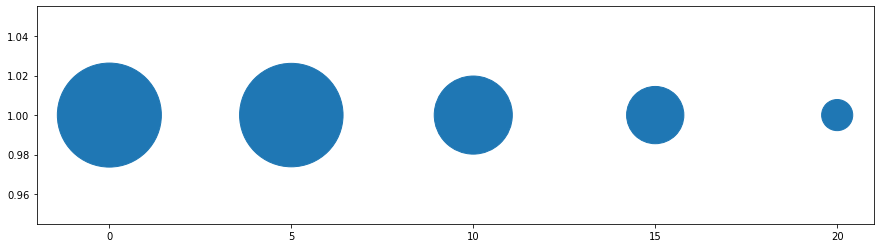

In [9]:
data = pivot.iloc[:5]["DV_plastic_weight"].to_list()

fig, ax = plt.subplots(figsize=(15, 4))
plt.scatter([0,5,10,15,20], [1,1,1,1,1], s=data)
plt.gca().set_xlim(xmin=-2)

#export to svg
plt.savefig(os.path.join(root, "outputs//bubbles.svg"))

plt.show()

## Largest category per month

In [10]:
pivot = df.groupby(["month","category_name"])["DV_plastic_weight"].sum().to_frame()
pivot.unstack()

DV_plastic_weight                                            \
category_name     Bags and film Bottles Cupboard and Hygiene Drinks Other   
month                                                                       
1                           769    1006                  273      2   118   
2                           541     796                  212     10   349   
3                           640     943                  380     12    53   
4                           565     658                  439      4    61   
5                           510     995                  245      5    30   
6                           394    1036                  358      1    59   
7                           466    1155                  199      8   130   
8                           626    1205                  435     10    33   
9                           402     696                  272      4    84   
10                          315     706                   29    NaN     7   
11                          511     801                   70      2    11   
12                          357     710                  368      4    33   

                                 
category_name Pots, tubs, trays  
month                            
1                          1133  
2                          1152  
3                          1162  
4                          1010  
5                          1036  
6                           879  
7                           865  
8                          1066  
9                           763  
10                          533  
11                          565  
12                          657

## Radar plot

In [11]:
# get bin number by day for heatmap calendar view 
pivot = df.groupby("date")["DV_plastic_weight"].sum()
counts, bin_edges = np.histogram(pivot, bins=5)
print(bin_edges)

pivot = df.groupby("date")["DV_plastic_weight"].sum()
pivot = pivot.to_frame()
day_bins = []

for weight in pivot["DV_plastic_weight"]:
    if weight <=81.8:
        day_bins.append(1)
    elif (weight > 81.8) & (weight <= 154.6):
        day_bins.append(2)   
    elif (weight > 154.6) & (weight <= 227.4):
        day_bins.append(3)  
    elif (weight > 227.3) & (weight <= 300.2):
        day_bins.append(4)      
    elif weight > 300.2:
        day_bins.append(5)  
        
pivot["day_bins"] = day_bins

pivot.to_csv("day_bins.csv")

[9.0 81.8 154.6 227.39999999999998 300.2 373.0]


In [12]:
pivot = df.groupby(["date", 
                    "week_commencing"])["DV_plastic_weight"].sum().to_frame().reset_index()

#append empty weight for missing week
new_values = [pd.to_datetime("2021-10-04"), pd.to_datetime("2021-10-04"), 0]
length = len(pivot)
pivot.loc[length] = new_values

pivot = pivot.sort_values(by="week_commencing")
pivot.head()

,date,week_commencing,DV_plastic_weight
0,2021-01-01,2020-12-28,91
1,2021-01-02,2020-12-28,135
2,2021-01-03,2020-12-28,55
8,2021-01-09,2021-01-04,156
7,2021-01-08,2021-01-04,54


In [18]:
colpalette.mpl_colors[0]

(0.984313725490196, 0.9019607843137255, 0.7725490196078432)

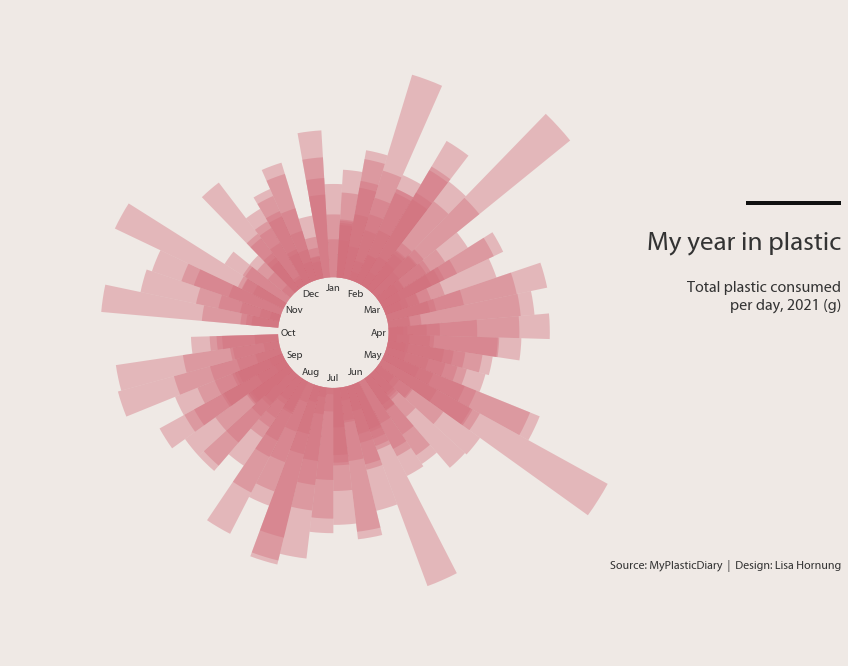

In [225]:
data = pivot

#set colour + get text properties
cols = {"back": "#efe9e5", "edges":"white", "text": "#333333", "title": "#111111", "bars": col_red}

# =========
# Initialise Figure and define layout
fig, ax = plt.subplots(figsize=(12,12))
fig.set_facecolor(cols["back"])
ax = plt.subplot(111, polar=True)

# ============
#data
n_points = len(data["week_commencing"].unique())
inner_radius = 80
bar1 = data["DV_plastic_weight"]

x_max = 2*np.pi
x_coords = np.linspace(0, x_max, n_points, endpoint=False)
width = x_max / n_points

#map x_coords to week commencing
dictionary = dict(zip(data["week_commencing"].unique(), x_coords))
x_pos = data["week_commencing"].map(dictionary)

#add bars
ax.bar(
    x_pos,
    bar1,
    width=width,
    bottom=inner_radius,
    color=cols["bars"],
    alpha=0.4
)

#============
# labels for months
l_points = 12
label_x_pos = np.linspace(0, x_max, l_points, endpoint=False)
labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

#add value labels and categories
for i in range(l_points):
    ax.text(label_x_pos[i], 65, 
            labels[i],
            size=10.5,
            ha="center", va='center',
           fontproperties=font_r,
           color=cols["text"])

#configure theta location and direction
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)

ax.axis('off')

## =========
#add accent line
laxes = fig.add_axes([0.99, 0.65, 0.11, 0.005]) #axes to hold colorbar
laxes.set_ylim(ymin=0, ymax=1)
laxes.set_facecolor("#111111")
for pos in ["top", "bottom", "left", "right"]:
    laxes.spines[pos].set_visible(False)
laxes.set_yticks([])
laxes.set_xticks([])


# =========
#title and footer
title = "My year in plastic"
subtitle = "Total plastic consumed\nper day, 2021 (g)"
x_title=1.1
plt.figtext(x_title,0.6, title, size=27, ha='right',  fontproperties = font_r, color=cols["text"])
plt.figtext(x_title,0.53, subtitle, size=16,ha='right', fontproperties = font_r, color=cols["text"],
           linespacing=1.3)

plt.figtext(x_title,0.23, "Source: MyPlasticDiary  |  Design: Lisa Hornung", 
            fontsize=12, ha='right', fontproperties = font_r, color=cols["text"])


#save
plt.savefig(os.path.join(root, "outputs//radar-plot.png"), bbox_inches="tight",pad_inches=0.4, transparent=False)
#plt.savefig(os.path.join(root, "outputs//radar-plot.svg"))

plt.show()

# Chart 1: Everyday tracking - calendar heatmap

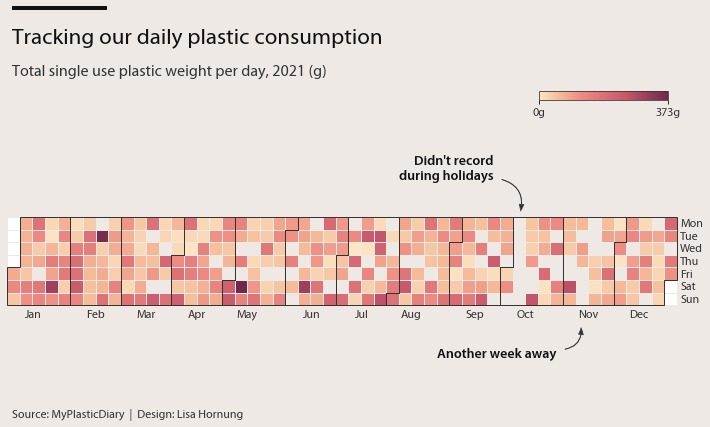

In [394]:
import calplot

#prepare data
all_days = pd.date_range('1/1/2021', periods=365, freq='D')
events = df_daily.groupby("date")["DV_plastic_weight"].sum()
events = pd.Series(events, index=all_days)

#set colour + get text properties
cols = {"back": "#efe9e5", "edges":"white", "text": "#333333", "title": "#111111"}

#colors
colpalette = BurgYl_7
col_main = colpalette.mpl_colors

title = ("Tracking our daily plastic consumption")
#.upper()
subtitle = "Total single use plastic weight per day, 2021 (g)"

#### plot
fig, ax = plt.subplots(figsize=(12,5))
fig.set_facecolor(cols["back"])
ax = calplot.yearplot(events, cmap=colpalette.mpl_colormap, linewidth=1, linecolor=cols["back"], fillcolor=cols["back"],
                      edgecolor = cols["text"],  dropzero=True)
ax.set_xticklabels(ax.get_xticklabels(), color=cols["text"], fontproperties=font_r, size=12)
ax.set_yticklabels(ax.get_yticklabels(), color=cols["text"], fontproperties=font_r, size=12)

# =========
# Arrows
#define style
style = "Simple, tail_width=0.5, head_width=5, head_length=7"
kw = dict(arrowstyle=style, color=cols["text"])

#define arrows
a1 = patches.FancyArrowPatch((7.5, 9.5), (7.5, 6.3),linewidth=0.5,
                            connectionstyle="arc3,rad=0", **kw, clip_on=False)
a2 = patches.FancyArrowPatch((39, 10), (40.6, 7.3),linewidth=0.5,
                            connectionstyle="arc3,rad=-.5", **kw, clip_on=False)
a3 = patches.FancyArrowPatch((44, -3.5), (45.4, -1.6),linewidth=0.5,
                            connectionstyle="arc3,rad=.5", **kw, clip_on=False)

#add arrows to plot
for a in [a2,a3]:
    ax.add_patch(a)

## =========
#annotations
#ax.text(7.5,10, "New bikes arrived\nwrapped in lots\nof plastic", fontsize=11, ha='center', fontproperties = font_m,
        #color=cols["title"])  
ax.text(38.5, 10, "Didn't record\nduring holidays", fontsize=14, ha='right', fontproperties = font_m, color=cols["title"])
ax.text(43.5, -4, "Another week away", fontsize=14, ha='right', fontproperties = font_m, color=cols["title"])

## =========
#add colorbar (create mappable first and then plot)
cbaxes = fig.add_axes([0.74, 0.95, 0.15, 0.025]) #axes to hold colorbar
cmappable = ScalarMappable(norm=Normalize(0,int(events.max())), cmap=colpalette.mpl_colormap)
cb = plt.colorbar(cmappable, cax = cbaxes, anchor=(1,1.2), orientation='horizontal',
            ticks=[0,  int(events.max())])
cb.set_ticklabels(["0g", str(int(events.max()))+"g" ], fontproperties=font_r, color=cols["text"],size=12)
cb.outline.set_color(cols["text"])    


## =========
#add accent line
laxes = fig.add_axes([0.13, 1.2, 0.11, 0.01]) #axes to hold colorbar
laxes.set_ylim(ymin=0, ymax=1)
laxes.set_facecolor("#111111")
for pos in ["top", "bottom", "left", "right"]:
    laxes.spines[pos].set_visible(False)
laxes.set_yticks([])
laxes.set_xticks([])

# =========
#title and footer
x_title=0.13
plt.figtext(x_title,1.11, title, size=23, ha='left',  fontproperties = font_r, color=cols["title"])
plt.figtext(x_title,1.02, subtitle, size=16,ha='left',  fontproperties = font_r, color=cols["text"])

plt.figtext(x_title,0.07, "Source: MyPlasticDiary  |  Design: Lisa Hornung", 
            fontsize=12, ha='left', fontproperties = font_r, color=cols["text"])

#save
plt.savefig(os.path.join(root, "outputs//chart1-calendar-heatmap.png"), bbox_inches="tight",pad_inches=0.4)

plt.show()

# Chart 2: Total consumption - bubbles

Credit for packed bubbles codes to [Matplotlib docs](https://matplotlib.org/devdocs/gallery/misc/packed_bubbles.html)

In [18]:
print("total items:", df["quantity"].sum())
print("total weight:", df["DV_plastic_weight"].sum())
print("max weight for single item:", df["DV_plastic_weight"].max())

total items: 2556
total weight: 31934
max weight for single item: 122


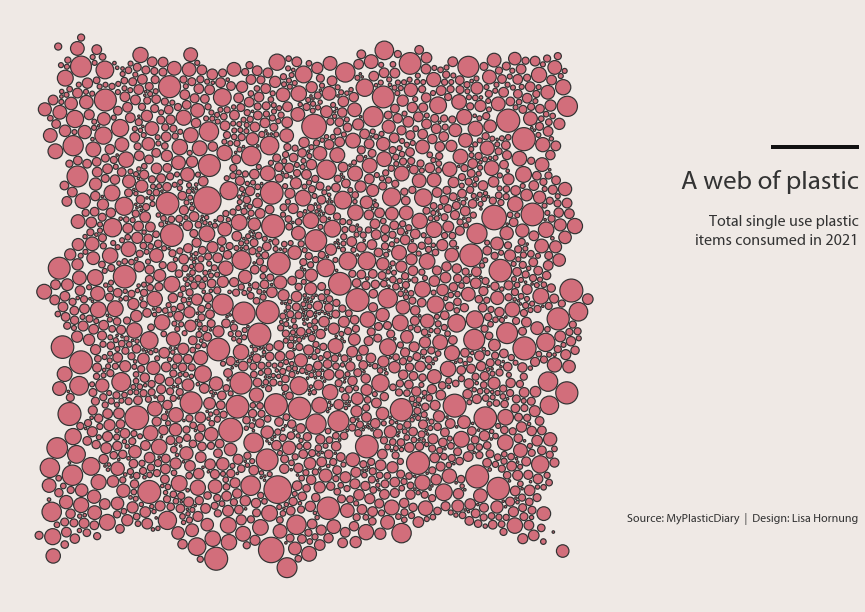

In [55]:
data = df[["category_name", "DV_plastic_weight"]]

#set colour + get text properties
cols = {"back": "#efe9e5", "edges":"white", "text": "#333333", "title": "#111111", "fill": col_red}

#create packed bubble charts
# credit: https://matplotlib.org/devdocs/gallery/misc/packed_bubbles.html
class BubbleChart:
    def __init__(self, area, bubble_spacing=0):
        """
        Setup for bubble collapse.

        Parameters
        ----------
        area : array-like
            Area of the bubbles.
        bubble_spacing : float, default: 0
            Minimal spacing between bubbles after collapsing.

        Notes
        -----
        If "area" is sorted, the results might look weird.
        """
        area = np.asarray(area)
        r = np.sqrt(area / np.pi)

        self.bubble_spacing = bubble_spacing
        self.bubbles = np.ones((len(area), 4))
        self.bubbles[:, 2] = r
        self.bubbles[:, 3] = area
        self.maxstep = 2 * self.bubbles[:, 2].max() + self.bubble_spacing
        self.step_dist = self.maxstep / 2

        # calculate initial grid layout for bubbles
        length = np.ceil(np.sqrt(len(self.bubbles)))
        grid = np.arange(length) * self.maxstep
        gx, gy = np.meshgrid(grid, grid)
        self.bubbles[:, 0] = gx.flatten()[:len(self.bubbles)]
        self.bubbles[:, 1] = gy.flatten()[:len(self.bubbles)]

        self.com = self.center_of_mass()

    def center_of_mass(self):
        return np.average(
            self.bubbles[:, :2], axis=0, weights=self.bubbles[:, 3]
        )

    def center_distance(self, bubble, bubbles):
        return np.hypot(bubble[0] - bubbles[:, 0],
                        bubble[1] - bubbles[:, 1])

    def outline_distance(self, bubble, bubbles):
        center_distance = self.center_distance(bubble, bubbles)
        return center_distance - bubble[2] - \
            bubbles[:, 2] - self.bubble_spacing

    def check_collisions(self, bubble, bubbles):
        distance = self.outline_distance(bubble, bubbles)
        return len(distance[distance < 0])

    def collides_with(self, bubble, bubbles):
        distance = self.outline_distance(bubble, bubbles)
        idx_min = np.argmin(distance)
        return idx_min if type(idx_min) == np.ndarray else [idx_min]

    def collapse(self, n_iterations=200):
        """
        Move bubbles to the center of mass.

        Parameters
        ----------
        n_iterations : int, default: 50
            Number of moves to perform.
        """
        for _i in range(n_iterations):
            moves = 0
            for i in range(len(self.bubbles)):
                rest_bub = np.delete(self.bubbles, i, 0)
                # try to move directly towards the center of mass
                # direction vector from bubble to the center of mass
                dir_vec = self.com - self.bubbles[i, :2]

                # shorten direction vector to have length of 1
                dir_vec = dir_vec / np.sqrt(dir_vec.dot(dir_vec))

                # calculate new bubble position
                new_point = self.bubbles[i, :2] + dir_vec * self.step_dist
                new_bubble = np.append(new_point, self.bubbles[i, 2:4])

                # check whether new bubble collides with other bubbles
                if not self.check_collisions(new_bubble, rest_bub):
                    self.bubbles[i, :] = new_bubble
                    self.com = self.center_of_mass()
                    moves += 1
                else:
                    # try to move around a bubble that you collide with
                    # find colliding bubble
                    for colliding in self.collides_with(new_bubble, rest_bub):
                        # calculate direction vector
                        dir_vec = rest_bub[colliding, :2] - self.bubbles[i, :2]
                        dir_vec = dir_vec / np.sqrt(dir_vec.dot(dir_vec))
                        # calculate orthogonal vector
                        orth = np.array([dir_vec[1], -dir_vec[0]])
                        # test which direction to go
                        new_point1 = (self.bubbles[i, :2] + orth *
                                      self.step_dist)
                        new_point2 = (self.bubbles[i, :2] - orth *
                                      self.step_dist)
                        dist1 = self.center_distance(
                            self.com, np.array([new_point1]))
                        dist2 = self.center_distance(
                            self.com, np.array([new_point2]))
                        new_point = new_point1 if dist1 < dist2 else new_point2
                        new_bubble = np.append(new_point, self.bubbles[i, 2:4])
                        if not self.check_collisions(new_bubble, rest_bub):
                            self.bubbles[i, :] = new_bubble
                            self.com = self.center_of_mass()

            if moves / len(self.bubbles) < 0.1:
                self.step_dist = self.step_dist / 2

    def plot(self, ax, labels, colors):
        """
        Draw the bubble plot.

        Parameters
        ----------
        ax : matplotlib.axes.Axes
        labels : list
            Labels of the bubbles.
        colors : list
            Colors of the bubbles.
        """
        for i in range(len(self.bubbles)):
            circ = plt.Circle(
                self.bubbles[i, :2], self.bubbles[i, 2], facecolor=cols["fill"], edgecolor=cols["text"],
            linewidth=1.2)
            ax.add_patch(circ)

bubble_chart = BubbleChart(area=data['DV_plastic_weight'].to_list(),
                           bubble_spacing=0.5)

bubble_chart.collapse()

#create figure
fig, ax = plt.subplots(figsize=(11,11))
fig.set_facecolor(cols["back"])
bubble_chart.plot(
    ax, data['category_name'], colors)
ax.axis("off")
ax.relim()
ax.autoscale_view()


## =========
#add accent line
laxes = fig.add_axes([1.09, 0.7, 0.11, 0.005]) #axes to hold colorbar
laxes.set_ylim(ymin=0, ymax=1)
laxes.set_facecolor("#111111")
for pos in ["top", "bottom", "left", "right"]:
    laxes.spines[pos].set_visible(False)
laxes.set_yticks([])
laxes.set_xticks([])


# =========
#title and footer
title = "A web of plastic"
subtitle = "Total single use plastic\nitems consumed in 2021"
x_title=1.2
plt.figtext(x_title,0.65, title, size=27, ha='right',  fontproperties = font_r, color=cols["text"])
plt.figtext(x_title,0.58, subtitle, size=16,ha='right', fontproperties = font_r, color=cols["text"],
           linespacing=1.4)

plt.figtext(x_title,0.23, "Source: MyPlasticDiary  |  Design: Lisa Hornung", 
            fontsize=12, ha='right', fontproperties = font_r, color=cols["text"])


#plt.savefig(os.path.join(root, "outputs//bubbles_sea.svg"))
plt.savefig(os.path.join(root, "outputs//bubbles_sea.png"), bbox_inches="tight",pad_inches=0.4)


plt.show()

# Chart 3: Number vs weight by category - scatter

If you want to take things further with a scatterplot, checkout [this great example](https://www.python-graph-gallery.com/web-scatterplot-astronaut).

In [190]:
labels_renamed = {'Bags and film': 'Bags and wrappings',
                           'Bottles': 'Bottles',
                           'Cupboard and Hygiene': 'Cupboard and\nHygiene',
                           'Drinks': 'Coffee cups',
                           'Other' : 'Other',
                           'Pots, tubs, trays':  'Pots and trays'}

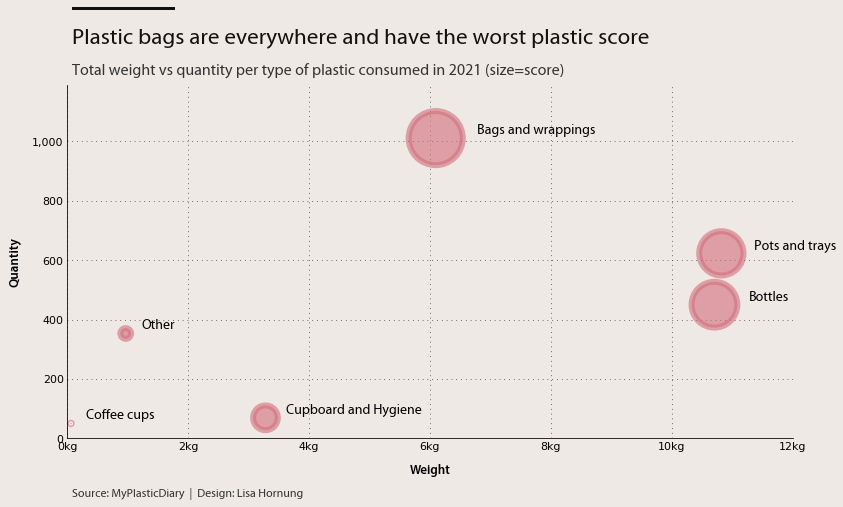

In [321]:
data = df.groupby(["category_name"]).agg({"DV_plastic_weight":"sum", "quantity":"sum", "score":"sum"}).reset_index()

#set colour + get text properties
cols = {"back": "#efe9e5", "edges":"white", "text": "#333333", "title": "#111111", "fill": col_red}

#initialise figure
fig, ax = plt.subplots(figsize=(13,6.5))
fig.set_facecolor(cols["back"])
ax.set_facecolor(cols["back"])

# =========
#data
x = np.divide(data["DV_plastic_weight"], 1000)
y = data["quantity"]
labels = data["category_name"].map(labels_renamed)
size = data["score"].to_list()

#plot data
plt.scatter(x, y, s=size, linewidth=6, alpha=0.6, color=cols["fill"], zorder=2)

#add labels
for i in range(len(data)):
    plt.text(x[i]+0.25+size[i]*0.00015 ,y[i]+15, labels[i], zorder=2, 
             fontproperties=font_r, size=14)

# =======
#style graph
for pos in ["top", "right"]:
    ax.spines[pos].set_visible(False)
ax.tick_params(axis='both', length = 0, color = "#111111", labelsize=11)
ax.grid(visible=True, axis='both', zorder=1, color = "#333333", linestyle=(0,(1,5)))

#yaxis
ax.set_ylim(ymin=0, ymax=1190)
ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x)))
    
#axis
ax.set_xlim(xmin=0, xmax=12)
ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, pos: '{:,.0f}kg'.format(x)))

# Adding and styling axis labels
plt.xlabel('Weight', loc='center', fontproperties = font_m, size=13, labelpad=12)
plt.ylabel('Quantity', loc='center', fontproperties = font_m, size=13, labelpad=12)

## =========
#add accent line
laxes = fig.add_axes([0.13, 1.04, 0.11, 0.007]) #axes to hold colorbar
laxes.set_ylim(ymin=0, ymax=1)
laxes.set_facecolor("#111111")
for pos in ["top", "bottom", "left", "right"]:
    laxes.spines[pos].set_visible(False)
laxes.set_yticks([])
laxes.set_xticks([])

# =========
#title and footer
title = "Plastic bags are everywhere and have the worst plastic score"
subtitle = "Total weight vs quantity per type of plastic consumed in 2021 (size=score)"

x_title=0.13
plt.figtext(x_title,0.97, title, size=23, ha='left',  fontproperties = font_r, color=cols["title"])
plt.figtext(x_title,0.9, subtitle, size=16,ha='left',  fontproperties = font_r, color=cols["text"])

plt.figtext(x_title,0.0, "Source: MyPlasticDiary  |  Design: Lisa Hornung", 
            fontsize=12, ha='left', fontproperties = font_r, color=cols["text"])


#save
plt.savefig(os.path.join(root, "outputs//scatter_by_category.png"), bbox_inches="tight",pad_inches=0.4)

plt.show()

# Chart 4: Reduction over time - stacked bar

How to fill plots with patterns in matplotlib --> [Useful article](https://towardsdatascience.com/how-to-fill-plots-with-patterns-in-matplotlib-58ad41ea8cf8)

In [373]:
labels_renamed = {'Bags and film': 'Bags and wrappings',
                           'Bottles': 'Bottles',
                           'Cupboard and Hygiene': 'Cupboard and Hygiene',
                           'Drinks': 'Coffee cups',
                           'Other' : 'Other',
                           'Pots, tubs, trays':  'Pots and trays'}

pivot = df.groupby(["week_commencing", "category_name"])["DV_plastic_weight"].sum().to_frame().unstack()
pivot.columns = pivot.columns.droplevel(level=0)
pivot = pivot.reset_index()

#exclude weeks where we didn't record consistently
pivot = pivot[(pivot["week_commencing"]!="2021-11-08") & 
              (pivot["week_commencing"]!="2021-11-15")].set_index("week_commencing")
pivot["Total"] = pivot.sum(axis=1)
pivot = pivot.fillna(0)
pivot = pivot[['Pots, tubs, trays', 'Bottles', 'Bags and film', 'Cupboard and Hygiene', 'Other']]
pivot.columns = pivot.columns.map(labels_renamed)
pivot.head()

category_name,Pots and trays,Bottles,Bags and wrappings,Cupboard and Hygiene,Other
week_commencing,,,,,
2020-12-28,125,126,28,0,0
2021-01-04,207,192,206,25,24
2021-01-11,280,175,152,148,25
2021-01-18,251,304,211,0,48
2021-01-25,270,209,172,100,21


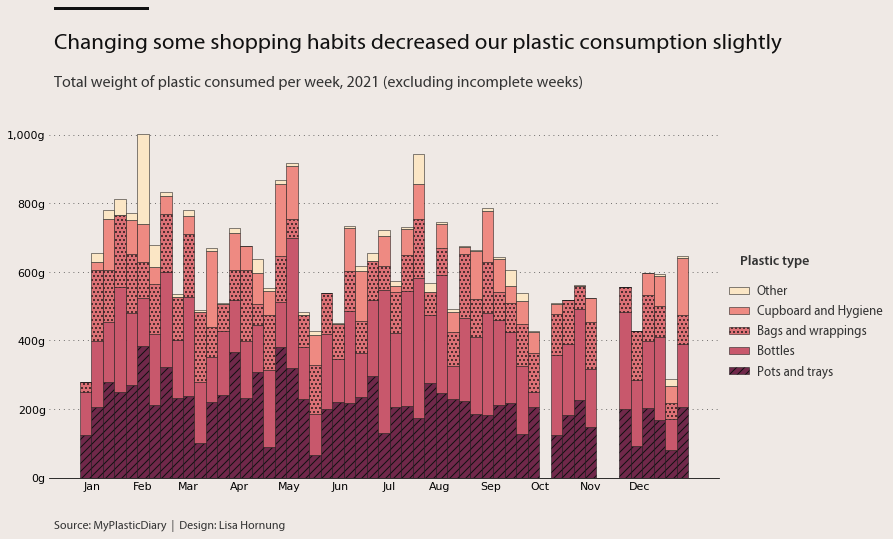

In [395]:
data = pivot

columns = pivot.columns 
hatches = [ "///" , "", "...", "", "", "", ""]
#hatches = [ "" , "", "", "", "", ""]

#Chart
fig, ax = plt.subplots(figsize=(12,7.5))
fig.set_facecolor(cols["back"])
ax.set_facecolor(cols["back"])                      

for i in range(len(columns)):
    if i == 0:
        plt.bar(data.index, data[columns[i]], width=7, color=colpalette_r.mpl_colors[i], 
                hatch=hatches[i], label=columns[i], linewidth=0.5, edgecolor="#111111", zorder=2)
    else:
        plt.bar(data.index, data[columns[i]], bottom=data[columns[:i]].sum(axis=1), width=7,
                color=colpalette_r.mpl_colors[i],  hatch=hatches[i], label=columns[i],
               linewidth=0.5, edgecolor="#111111", zorder=2)
            
#style chart
for pos in ["top", "right", "left"]:
    ax.spines[pos].set_visible(False)

#axis
ax.tick_params(axis='both', length = 0, color = "#111111", labelsize=11)
ax.grid(visible=True, axis='y', zorder=1, color = "#333333", linestyle=(0,(1,5)))

#yaxis
ax.set_ylim(ymin=0, ymax=1190)
ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, pos: '{:,.0f}g'.format(x)))    

#xaxis
ticks = mdates.date2num(np.array([datetime(2021,1,1), datetime(2021,2,1), datetime(2021,3,1), datetime(2021,4,1),
                        datetime(2021,5,1), datetime(2021,6,1), datetime(2021,7,1), datetime(2021,8,1),
                        datetime(2021,9,1), datetime(2021,10,1), datetime(2021,11,1), datetime(2021,12,1)]))

plt.xticks(ticks, ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
    
#===========
#add legend in reverse order to match chart

#get handles and labels
handles, labels = plt.gca().get_legend_handles_labels()

#specify order of items in legend
order = [4,3,2,1,0]

#add legend to plot
L = fig.legend([handles[idx] for idx in order],[labels[idx] for idx in order], 
           bbox_to_anchor=(1.1, 0.5), frameon=False, labelspacing=0.7)
plt.setp(L.texts, fontproperties=font_r, fontsize=13, color=cols["text"])
plt.figtext(0.925 ,0.52, "Plastic type", size=14, ha='left',  fontproperties = font_m, color=cols["text"])

## =========
#add accent line
laxes = fig.add_axes([0.13, 0.99, 0.11, 0.007]) #axes to hold colorbar
laxes.set_ylim(ymin=0, ymax=1)
laxes.set_facecolor("#111111")
for pos in ["top", "bottom", "left", "right"]:
    laxes.spines[pos].set_visible(False)
laxes.set_yticks([])
laxes.set_xticks([])

# =========
#title and footer
title = "Changing some shopping habits decreased our plastic consumption slightly"
subtitle = "Total weight of plastic consumed per week, 2021 (excluding incomplete weeks)"

x_title=0.13
plt.figtext(x_title,0.92, title, size=23, ha='left',  fontproperties = font_r, color=cols["title"])
plt.figtext(x_title,0.85, subtitle, size=16,ha='left',  fontproperties = font_r, color=cols["text"])

plt.figtext(x_title,0.03, "Source: MyPlasticDiary  |  Design: Lisa Hornung", 
            fontsize=12, ha='left', fontproperties = font_r, color=cols["text"])


#save
plt.savefig(os.path.join(root, "outputs//stacked_bar_over_time_pattern.png"), bbox_inches="tight",pad_inches=0.4)

plt.show()

## Chart 5: Plastic period - done in illustrator

## Chart 6: Benchmark - 

## Not used

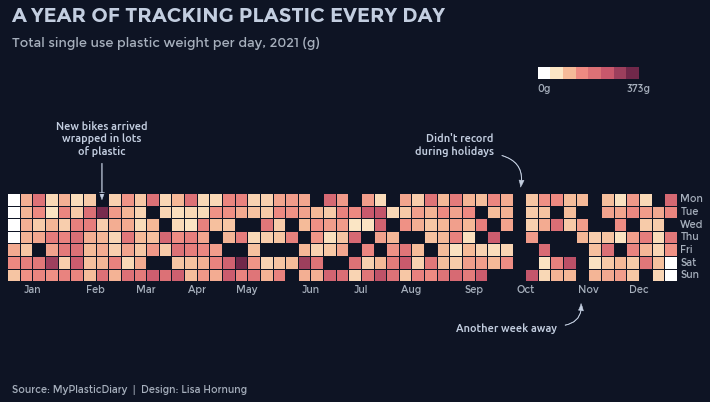

In [61]:
import calplot

#prepare data
all_days = pd.date_range('1/1/2021', periods=365, freq='D')
events = df_daily.groupby("date")["DV_plastic_weight"].sum()
events = pd.Series(events, index=all_days)

#set colour + get text properties
cols = {"back": "#0e1424", "edges":"#c3cee0", "text": "#a6afbc", "title": "#c3cee0"}
font_r, font_b, title, subtitle = get_text()

#### plot
fig, ax = plt.subplots(figsize=(12,5))
fig.set_facecolor(cols["back"])
ax = calplot.yearplot(events, cmap=colpalette.mpl_colormap, linewidth=1, linecolor=cols["back"], fillcolor=cols["back"],
                      edgecolor = cols["back"],  dropzero=True)
ax.set_xticklabels(ax.get_xticklabels(), color=cols["text"], fontproperties=font_r)
ax.set_yticklabels(ax.get_yticklabels(), color=cols["text"], fontproperties=font_r)

# =========
# Arrows
#define style
style = "Simple, tail_width=0.5, head_width=5, head_length=7"
kw = dict(arrowstyle=style, color=cols["title"])

#define arrows
a1 = patches.FancyArrowPatch((7.5, 9.5), (7.5, 6.3),linewidth=0.5,
                            connectionstyle="arc3,rad=0", **kw, clip_on=False)
a2 = patches.FancyArrowPatch((39, 10), (40.6, 7.3),linewidth=0.5,
                            connectionstyle="arc3,rad=-.5", **kw, clip_on=False)
a3 = patches.FancyArrowPatch((44, -3.5), (45.4, -1.6),linewidth=0.5,
                            connectionstyle="arc3,rad=.5", **kw, clip_on=False)

#add arrows to plot
for a in [a1, a2,a3]:
    ax.add_patch(a)

## =========
#annotations
ax.text(7.5,10, "New bikes arrived\nwrapped in lots\nof plastic", fontsize=11, ha='center', fontproperties = font_m,
        color=cols["title"])  
ax.text(38.5, 10, "Didn't record\nduring holidays", fontsize=11, ha='right', fontproperties = font_m, color=cols["title"])
ax.text(43.5, -4, "Another week away", fontsize=11, ha='right', fontproperties = font_m, color=cols["title"])

## =========
#add colorbar (custom ...)
x_pos = 42
y_pos = 16

ax.text(x_pos,y_pos-1, "0g", fontsize=10, ha='left', fontproperties = font_r, color=cols["text"])  
ax.add_patch(patches.Rectangle((x_pos, y_pos), 1, 1, edgecolor=None, facecolor='white', linewidth=0.7, clip_on=False))
for c in colpalette.mpl_colors:
    ax.add_patch(patches.Rectangle((x_pos+1, y_pos), 1, 1, edgecolor=None, facecolor=c, linewidth=0.7, clip_on=False))
    x_pos +=1
ax.text(x_pos,y_pos-1, str(int(events.max()))+"g", fontsize=10, ha='left', fontproperties = font_r, color=cols["text"])  

# =========
#title and footer
x_title=0.13
plt.figtext(x_title,1.1, title, size=20, ha='left',  fontproperties = font_b, color=cols["title"])
plt.figtext(x_title,1.03, subtitle, size=13,ha='left',  fontproperties = font_r, color=cols["text"])

plt.figtext(x_title,0.07, "Source: MyPlasticDiary  |  Design: Lisa Hornung", 
            fontsize=10, ha='left', fontproperties = font_r, color=cols["text"])

#save
plt.savefig(os.path.join(root, "outputs//chart1-calendar-heatmap.png"), bbox_inches="tight",pad_inches=0.2)

plt.show()